# Simulation of XYZ spin models using Floquet engineering in XY mode

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import qutip

import pulser
from pulser import Pulse, Sequence, Register
from pulser_simulation import Simulation
from pulser.devices import MockDevice, Chadoq2
from pulser.waveforms import BlackmanWaveform

In this notebook, we attempt to create a ferromagnetic XXX spin chain with open boundary conditions, with a field applied in the Z direction only on the edges of the chain. This is broadly taken from "Microwave-engineering of programmable XXZ Hamiltonians in arrays of Rydberg atoms", P. Scholl, et. al., https://arxiv.org/pdf/2107.14459.pdf.

### Open chain with XXX chain

The initial state will be in the $S=0$ state (a Hadamard on all). The time evolution should preserve $S=0$.

Let us first define our $\pm X$ and  $\pm Y$ pulses. 

In [29]:
# Times are in ns
t_pulse = 26

X_pulse = Pulse.ConstantDetuning(BlackmanWaveform(t_pulse, np.pi / 2.0), 0, 0)
Y_pulse = Pulse.ConstantDetuning(
    BlackmanWaveform(t_pulse, np.pi / 2.0), 0, -np.pi / 2
)
mX_pulse = Pulse.ConstantDetuning(
    BlackmanWaveform(t_pulse, np.pi / 2.0), 0, np.pi
)
mY_pulse = Pulse.ConstantDetuning(
    BlackmanWaveform(t_pulse, np.pi / 2.0), 0, np.pi / 2
)

def delay_pulse(time, field):
    return Pulse.ConstantPulse(time, 0, field, 0)

Let's also define a function to add the pulses during one cycle. This creates n_cycles of the hamiltonian. Each pulse lasts t_pulse. 

In [31]:
#this creates and XXZ floquet term, you can tune the Z term through the proportion of tau_1 and tau_2
def Floquet_XXZ_cycles(n_cycles, tau_1, tau_2, t_pulse):
    t_half = t_pulse / 2.0
    tau_3 = tau_2
    tc = 4 * tau_2 + 2 * tau_1
    for _ in range(n_cycles):
        seq.delay(tau_1 - t_half, "MW")
        seq.add(X_pulse, "MW")
        seq.delay(tau_2 - 2 * t_half, "MW")
        seq.add(mY_pulse, "MW")
        seq.delay(2 * tau_3 - 2 * t_half, "MW")
        seq.add(Y_pulse, "MW")
        seq.delay(tau_2 - 2 * t_half, "MW")
        seq.add(mX_pulse, "MW")
        seq.delay(tau_1 - t_half, "MW")

#this creates and XXZ floquet term, you can tune the Z term through the proportion of tau_1 and tau_2
def Floquet_XXZ_cycles_field(n_cycles, tau_1, tau_2, t_pulse, field):
    t_half = t_pulse / 2.0
    tau_3 = tau_2
    tc = 4 * tau_2 + 2 * tau_1
    for _ in range(n_cycles):
        #seq.delay(tau_1 - t_half, "MW")
        seq.add(delay_pulse(tau_1 - t_half, field), 'MW')
        seq.add(X_pulse, "MW")
        #seq.delay(tau_2 - 2 * t_half, "MW")
        seq.add(delay_pulse(tau_2 - 2 * t_half, field), 'MW')
        seq.add(mY_pulse, "MW")
        #seq.delay(2 * tau_3 - 2 * t_half, "MW")
        seq.add(delay_pulse(2 * tau_3 - 2 * t_half, field), 'MW')
        seq.add(Y_pulse, "MW")
        #seq.delay(tau_2 - 2 * t_half, "MW")
        seq.add(delay_pulse(tau_2 - 2 * t_half, field), 'MW')
        seq.add(mX_pulse, "MW")
        #seq.delay(tau_1 - t_half, "MW")
        seq.add(delay_pulse(tau_1 - t_half, field), 'MW')

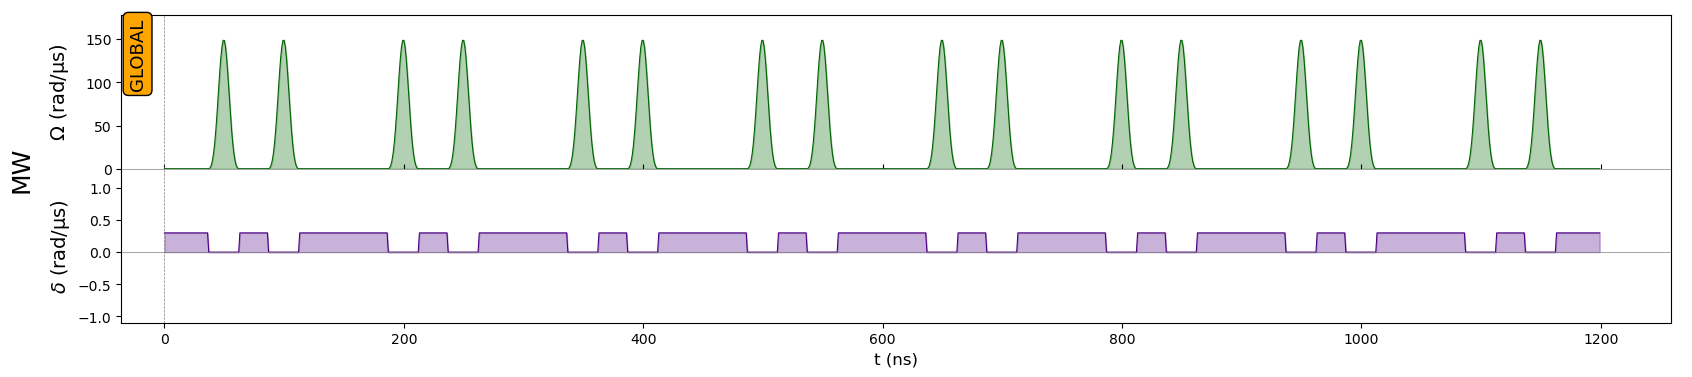

In [32]:
# show a sequence of 4 Floquet cycles
# We take two atoms distant by 10 ums.
coords = np.array([[0, 0], [10, 0]])
qubits = dict(enumerate(coords))
reg = Register(qubits)

seq = Sequence(reg, MockDevice)
seq.declare_channel("MW", "mw_global")
seq.set_magnetic_field(0.0, 0.0, 1.0) #magnetic field in the Z direction, perpendicular to the atoms themselves

tc = 300
Floquet_XXZ_cycles_field(4, tc / 6.0, tc / 6.0, t_pulse, 0.3)
seq.draw()

We are ready to start building our sequence.

In [9]:
N_at = 10 #number of atoms
# Number of Floquet cycles
N_cycles = 20
# In the following, we will take 1000 projective measurements of the system at the final time.
N_samples = 1000

In the experiment, all the atoms start in the same initial state. In order to create $S=0$ state, we apply a $\pi/2$ pulse in the X direction to all of them (Hadamard)

In [34]:
initial_H_pulse = Pulse.ConstantDetuning(
    BlackmanWaveform(t_pulse, np.pi/2), 0, 0
)
#not too quick for this pulse, otherwise poor H state.

In [35]:
# Line geometry
# Circular geometry
coords = (
    10.0
    * N_at
    / (2 * np.pi)
    * np.array(
        [
            (
                np.cos(theta * 2 * np.pi / N_at),
                np.sin(theta * 2 * np.pi / N_at),
            )
            for theta in range(N_at)
        ]
    )
)
#circle - PBC
#reg = Register.from_coordinates(coords)
#line - OBC
reg = Register.rectangle(1, N_at, 10)
magnetizations_obc = np.zeros((N_at, N_cycles), dtype=float) #mag for each atom after each cycle
correl_obc = np.zeros(N_cycles, dtype=float)
for m in range(N_cycles):  # Runtime close to 2 min!
    seq = Sequence(reg, MockDevice)
    seq.declare_channel("MW", "mw_global")
    seq.set_magnetic_field(0.0, 0.0, 1.0)
    # Configure the SLM mask, that will prevent the masked qubits from interacting with the first global \pi pulse
    #seq.config_slm_mask(masked_indices)
    seq.add(initial_H_pulse, "MW")
    #for the rest of the pulses, the SLM mask will not apply
    Floquet_XXZ_cycles(m, tc / 6.0, tc / 6.0, t_pulse)
    sim = Simulation(seq)
    res = sim.run()
    samples = res.sample_final_state(N_samples)
    correl = 0.0
    for key, value in samples.items():
        for j in range(N_at):
            correl -= (
                (2 * float(key[j]) - 1)
                * (2 * float(key[(j + 1) % N_at]) - 1)
                * value
                / N_samples
            )
            magnetizations_obc[j][m] += (
                (2 * float(key[j]) - 1) * value / N_samples
            )
    correl_obc[m] = N_at / 2 + correl / 2  #S.S correlation in the Z basis

Let's plot the evolution of the magnetization $\langle \sigma^z_j \rangle$ in time for all the sites $j$.

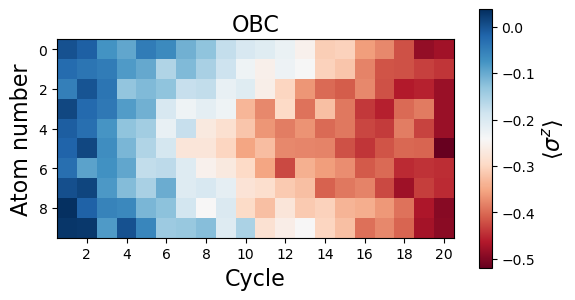

In [40]:
fig, ax = plt.subplots()
img = ax.imshow(magnetizations_obc, cmap=plt.get_cmap("RdBu"))
plt.title("OBC", fontsize=16)
ax.set_xlabel("Cycle", fontsize=16)
ax.set_ylabel("Atom number", fontsize=16)
xticks_loc = []
xticks = []
for i in range(N_cycles):
    if i % 2 != 0:
        xticks_loc.append(i)
        xticks.append('{}'.format(i+1))
ax.set_xticks(xticks_loc)
ax.set_xticklabels(xticks);
cbar = fig.colorbar(img, shrink=0.7)
cbar.set_label(r"$\langle \sigma^z \rangle$", fontsize=16)

There is a small $Z$ field polarizing the results! Maybe this is due to poor preparation of the $S=0$ state at $t=0$

# Full sequence with field only on sites 1 and N

In [42]:
N_at = 10 #number of atoms
# Number of Floquet cycles
N_cycles = 20
# In the following, we will take 1000 projective measurements of the system at the final time.
N_samples = 1000
tc = 300

initial_H_pulse = Pulse.ConstantDetuning(
    BlackmanWaveform(t_pulse, np.pi/2), 0, 0
)
#not too quick for this pulse, otherwise poor H state.
field = 5

Problem!! The SLM can only be configured once, to add on the first pulse only. 

"Since the SLM mask is mostly useful for state preparation, its use in Pulser is restricted to the first pulse in the sequence. This can be seen by adding an extra pulse in the previous example and drawing the sequence. " See https://pulser.readthedocs.io/en/stable/tutorials/slm_mask.html 

This is an interesting situation. Maybe the problem can be rotated in some way to make that useful?

In [44]:
# Line geometry
reg = Register.rectangle(1, N_at, 10)
masked_indices = np.arange(2,N_at)
magnetizations_obc = np.zeros((N_at, N_cycles), dtype=float) #mag for each atom after each cycle
correl_obc = np.zeros(N_cycles, dtype=float)
for m in range(N_cycles):  # Runtime close to 2 min!
    seq = Sequence(reg, MockDevice)
    seq.declare_channel("MW", "mw_global")
    seq.set_magnetic_field(0.0, 0.0, 1.0)
    # Configure the SLM mask, that will prevent the masked qubits from interacting with the first global \pi pulse
    #seq.config_slm_mask(masked_indices)
    seq.add(initial_H_pulse, "MW") #puts qubits in S=0 state through global Hadamard 
    #apply the Floquet unitaries
    #magnetic field only on the 1st and 10th
    t_half = t_pulse / 2.0
    tau_1 = tau_2 = tau_3 = tc / 6.0
    for _ in range(N_cycles):
        #seq.delay(tau_1 - t_half, "MW")
        seq.config_slm_mask(masked_indices)
        seq.add(delay_pulse(tau_1 - t_half, field), 'MW') #masked qubits (bulk of chain) do not feel the field
        seq.add(X_pulse, "MW")
        #seq.delay(tau_2 - 2 * t_half, "MW")
        seq.config_slm_mask(masked_indices)
        seq.add(delay_pulse(tau_2 - 2 * t_half, field), 'MW')
        seq.add(mY_pulse, "MW")
        #seq.delay(2 * tau_3 - 2 * t_half, "MW")
        seq.config_slm_mask(masked_indices)
        seq.add(delay_pulse(2 * tau_3 - 2 * t_half, field), 'MW')
        seq.add(Y_pulse, "MW")
        #seq.delay(tau_2 - 2 * t_half, "MW")
        seq.config_slm_mask(masked_indices)
        seq.add(delay_pulse(tau_2 - 2 * t_half, field), 'MW')
        seq.add(mX_pulse, "MW")
        #seq.delay(tau_1 - t_half, "MW")
        seq.config_slm_mask(masked_indices)
        seq.add(delay_pulse(tau_1 - t_half, field), 'MW')
    sim = Simulation(seq)
    res = sim.run()
    samples = res.sample_final_state(N_samples)
    correl = 0.0
    for key, value in samples.items():
        for j in range(N_at):
            correl -= (
                (2 * float(key[j]) - 1)
                * (2 * float(key[(j + 1) % N_at]) - 1)
                * value
                / N_samples
            )
            magnetizations_obc[j][m] += (
                (2 * float(key[j]) - 1) * value / N_samples
            )
    correl_obc[m] = N_at / 2 + correl / 2  #S.S correlation in the Z basis

ValueError: SLM mask can be configured only once.